## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title and notebook title `SL_TP2_NAME1_NAME2` (or `SL_TP2_NAME` if you work alone).

**Deadline: Friday, January 9, 11:59 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2025/TD0_QLearning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
  # install rlberry library
  !pip install scipy rlberry

# Small MDP with unknown dynamics: TD(0) and Q-Learing

**The problem is the same as the last practical session: store management. The first few cells set up the environment and provide helpful tools like a policy iteration algorithm to compute the optimal policy if the MDP is known.**

**The goal of this practical session is to implement algorithms for finding the optimal policy when the MDP is unknown.**


You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [2]:
import numpy as np
import random as rd
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

### Problem parameters

In [3]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

As an example of demand distribution, we choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. We provide below a function that simulate the demand. 

In [4]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  6


### Encoding the MDP as a gymnasium environment

This is just a  toy example on how to create a gymnasium environement. 

Note that our environement is an example of tabular MDP for which the transition probabilities $P(s'|s,a)$ and the mean rewards $r(s,a)$ can actually be computed in closed form. Therefore we provide the transitions $(P)$ and mean rewards $(r)$ as attributes of the class. 

In [5]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        pdem = np.array([q*(1-q)**m for m in range(M+1)])
        pdem[M] = pdem[M]+1-np.sum(pdem)
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

        # computation of the MDP parameters
        P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
        r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a
        ## iteration over all possible states, actions, and possible demand values
        for a in range(M+1):
            for s in range(M+1):
                for d in range(M+1):
                    # next state and reward with demand d
                    ns = max(0,min(M,s+a) -d)
                    reward = -c*a - h*s+p*min(M,d,s+a)
                    if (a>0):
                        reward = reward - c0
                    P[s,a,ns] += pdem[d]
                    r[s,a] += pdem[d] * reward
        self.P = P # P[s,a,ns] = P(ns | s,a)
        self.r = r # r[s,a] = r(s,a)

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 5 elements: observation / reward / termination? / truncation ? / information  
        return self.state, reward, False, False,{}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

In [6]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T)
    States = np.zeros(T)
    env=StoreManagement(s0)
    for t in range(T):
        States[t]=env.state
        action=Pi(env.state)
        state,rew,_,_,_=env.step(action)
        Rewards[t]=rew
    return States,Rewards

### Some simple policies

In [7]:
def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

### Policy evaluation using the matrix inversion technique

Since the MDP is small, if we know the reward and transition distributions we can compute the value of a policy with the matrix inversion method.

In [39]:
env = StoreManagement(0,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1)
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

# MDP parameters
P = env.P # P[s,a,s'] = p(s' | s,a) 
r = env.r # r[s,a] = average reward received in state s when playing action a

In [9]:
def EvaluatePolicy(Pi):
    # input: function (could also be vector as we can only use this method for deterministic policies)
    r_Pi=np.zeros((M+1,1))
    P_Pi=np.zeros((M+1,M+1))
    for s in range(M+1):
        P_Pi[s,:]=P[s,Pi(s),:] # matrix P^\pi
        r_Pi[s]=r[s,Pi(s)] # vector r^\pi
    V = np.linalg.inv(np.eye(M+1) - gamma * P_Pi) @ r_Pi
    return V.transpose()[0]

Values = EvaluatePolicy(PiThreshold)
print(Values)

[48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]


### Policy iteration

If the MDP is known, we can compute the optimal policy with policy iteration.

In [10]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and 
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV

def PolicyIteration():
    # initalization 
    Pi = np.zeros(M+1)
    V = np.zeros(M+1)
    # new policy 
    newPi = np.random.randint(M+1,size=M+1) 
    newPi[0]=1
    nIt = 0 
    while (not (Pi==newPi).all()):
        nIt +=1 
        Pi = np.copy(newPi)
        # evaluate the policy (transformed into a function)
        def PiFun(s):
            return Pi[s]
        V = EvaluatePolicy(PiFun)
        newPi,x = Improve(V)
    return Pi,V,nIt  # Policy, value, number of iterations

In [10]:
start = time.time()
Pi2,V2,nIt2 = PolicyIteration()
elapsed = time.time()-start

print("Optimal policy is",Pi2,"with value ",V2," in ",nIt2," iterations and t=",elapsed," seconds")

Optimal policy is [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0] with value  [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]  in  4  iterations and t= 0.008355140686035156  seconds


# Learning in a MDP with unknown dynamics

Now we consider reinforcement learning algorithms, who cannot make use of the knowledge of P and R, but can only simulate transistions.

## Stochastic Approximation for Policy Evaluation: TD(0)

TD(0) is an algorithm for policy evaluation: given a policy, we want to compute an accurate estimate of its value V.
It can be seen as parallel Robbins-Monro algorithms, one per state.

The algorithm starts from a random value vector V and a random state s0, then performs T transitions, taking actions according to the policy we want to evaluate. At each transition (from $s$ to $s'$, with reward $r$), it increments the visitation count $N(s)$ of the current state, then performs a Robbins-Monro update

$V(s) \leftarrow V(s) + \alpha_{N(s)}(r + \gamma V(s') - V(s))$

See lecture 3 for the full pseudo-code.

**Implement TD(0) with step size $\alpha_{N(s)} = 1/\sqrt{N(s)}$**


In [42]:
def TD0(Pi, T, beta=0.5):  # Pi: policy to be evaluated, T: number of iterations
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)

    s = s0
    for t in range(T):
        # Choose an action from Pi(s).
        action=Pi(s)
        # Simulate a step : obtain the new state and reward 
        s_new, reward, _,_, _  = env.step(action)
        # Increment the step to N[s]
        N[s]+=1
        # Calculate the learning rate : alpha = 1.0 / sqrt(N[s])
        alpha = 1.0 / (N[s]**beta)
        # Update: V[s] = V[s] + alpha * (r + gamma * V[s'] - V[s])
        V[s] = V[s] + alpha * (reward + gamma * V[s_new] - V[s])
        # Update the state : s = s'
        s = s_new

    return(V)

**Use TD(0) to compute the value of one of the simple policies defined in the introduction.**

To check that value, plot the error between the estimated value of TD(0) and the value computed by matrix inversion $\Vert V_{TD(0)} - V_{MI} \Vert_\infty$, as a function of the number of transitions $T$ used in TD(0).

Comment on the number of iterations needed to have a good estimate.

Calcul de TD(0) pour différentes durées T...
T=10, Erreur=51.3852
T=100, Erreur=51.4732
T=500, Erreur=52.6209
T=1000, Erreur=50.9119
T=5000, Erreur=51.2515
T=10000, Erreur=53.4769
T=50000, Erreur=53.5975
T=100000, Erreur=51.1557
T=500000, Erreur=51.3141
T=1000000, Erreur=51.2612


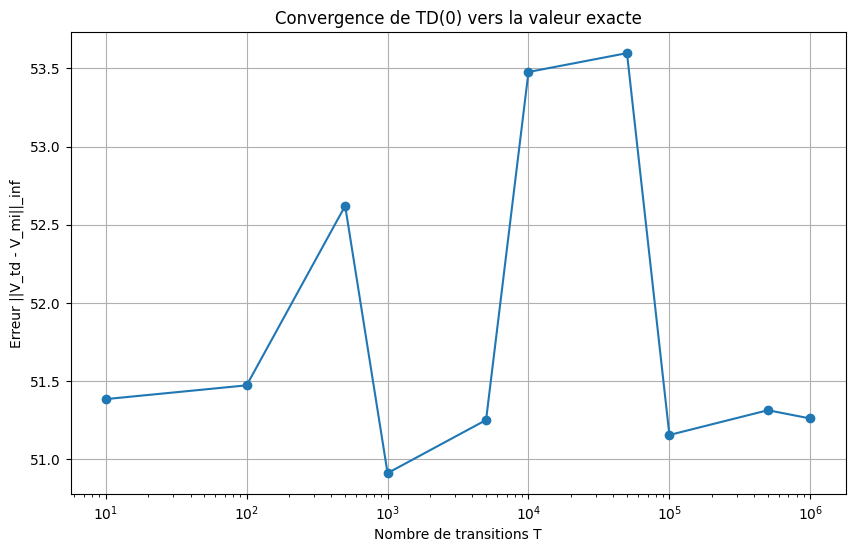

In [35]:
T_values = [10, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000] # truncation of the infinite sum

# V_TD0 = TD0(PiUniform,T)
V_matrix_inversion = EvaluatePolicy(PiThreshold)
errors = []

print("Calcul de TD(0) pour différentes durées T...")

for T in T_values:
    # TD0 calculation
    V_td = TD0(PiThreshold, T)
    
    # Calculate the error (Infinite Norm = Max absolute value of the difference)
    error = np.max(np.abs(V_td - V_matrix_inversion))
    errors.append(error)
    print(f"T={T}, Erreur={error:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(T_values, errors, marker='o', linestyle='-')
plt.xscale('log') 
plt.xlabel('Nombre de transitions T')
plt.ylabel('Erreur ||V_td - V_mi||_inf')
plt.title('Convergence de TD(0) vers la valeur exacte')
plt.grid(True)
plt.show()

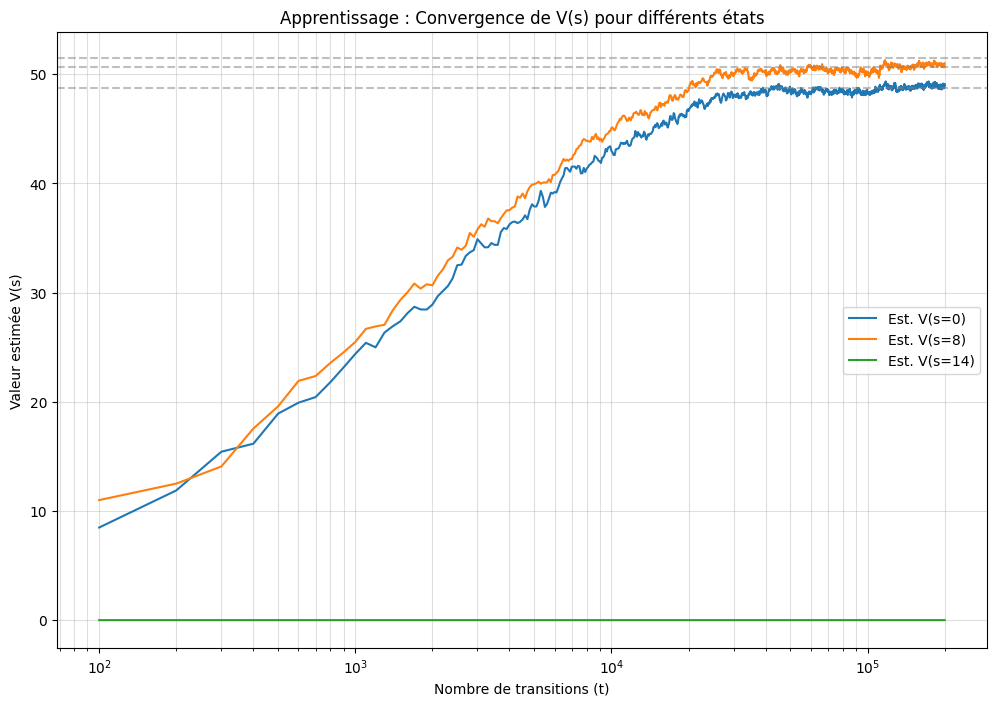

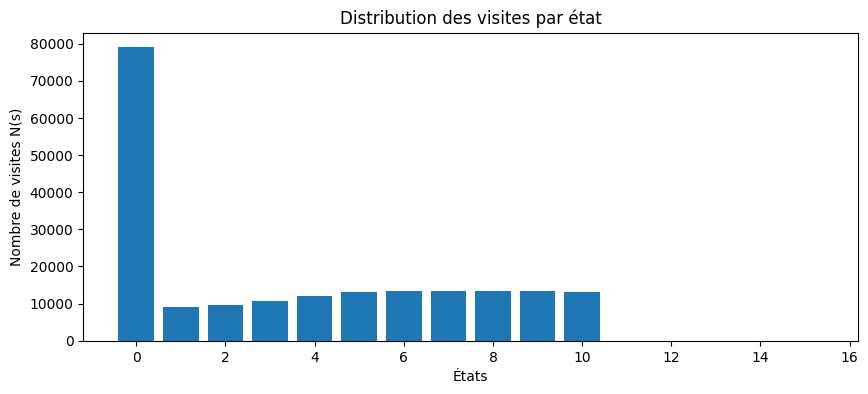

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def TD0_history(policy, T_max, env, record_every=100):
    # Récupération de la taille de l'espace d'états
    n_states = env.observation_space.n
    V = np.zeros(n_states)
    N = np.zeros(n_states)
    
    history_V = [] 
    history_iterations = []
    
    init_val = np.random.randint(n_states)
    env.reset(InitialStock=init_val) 
    s = init_val # On force 's' à prendre la valeur car env.reset renvoie None
    
    for t in range(1, T_max + 1):
        # Choix de l'action 
        if callable(policy):
            action = policy(s)
        else:
            action = np.random.choice(env.action_space.n, p=policy[s])
            
        # Appel de step
        s_prime, reward, done, truncated, _ = env.step(action)
        
        # Mise à jour TD(0)
        N[s] += 1
        alpha = 1.0 / np.sqrt(N[s])
        
        td_target = reward + gamma * V[s_prime]
        V[s] = V[s] + alpha * (td_target - V[s])
        
        
        if done or truncated:
            init_val = np.random.randint(n_states)
            env.reset(InitialStock=init_val)
            s = init_val
        else:
            s = s_prime
            
        # Enregistrement 
        if t % record_every == 0:
            history_V.append(V.copy())
            history_iterations.append(t)
            
    return np.array(history_iterations), np.array(history_V), N


# Paramètres
T_max = 200000 
record_every = 100 


V_true = EvaluatePolicy(PiThreshold) 

# Exécution de TD0
iterations, V_hist, N_counts = TD0_history(PiThreshold, T_max, env, record_every=record_every)

# Évolution de la valeur pour quelques états
n_total_states = env.observation_space.n
states_to_plot = [0, n_total_states//2, n_total_states-2] 

plt.figure(figsize=(12, 8))

for s_idx in states_to_plot:
    # On trace l'estimation TD(0)
    plt.plot(iterations, V_hist[:, s_idx], label=f'Est. V(s={s_idx})')
    # On trace la vraie valeur (ligne pointillée)
    plt.axhline(y=V_true[s_idx], color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xlabel('Nombre de transitions (t)')
plt.ylabel('Valeur estimée V(s)')
plt.title('Apprentissage : Convergence de V(s) pour différents états')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.show()

# Fréquence de visite
plt.figure(figsize=(10, 4))
plt.bar(range(n_total_states), N_counts)
plt.xlabel('États')
plt.ylabel('Nombre de visites N(s)')
plt.title('Distribution des visites par état')
plt.show()

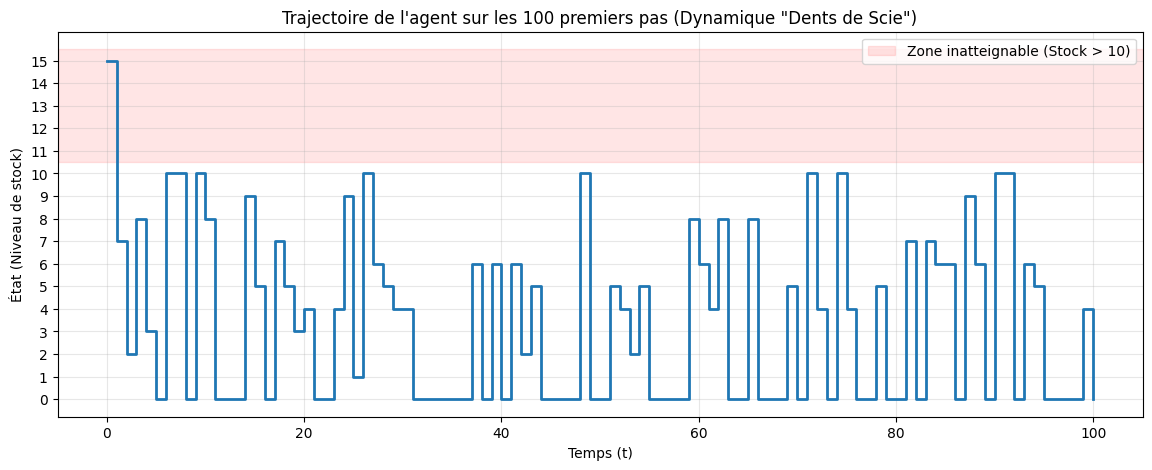

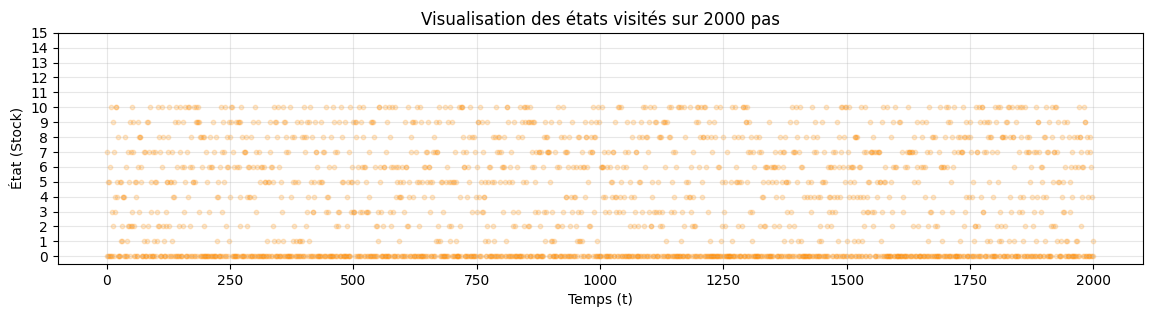

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def get_trajectory(policy, T_steps, env):
    """
    Simule l'agent et enregistre simplement la suite des états visités.
    """
    trajectory = []
    
    
    n_states = env.observation_space.n
    init_val = np.random.randint(n_states)
    env.reset(InitialStock=init_val)
    s = init_val
    
    trajectory.append(s)
    
    for t in range(T_steps):
        # Choix action
        if callable(policy):
            action = policy(s)
        else:
            action = np.random.choice(env.action_space.n, p=policy[s])
            
        # Step
        s_prime, reward, done, truncated, _ = env.step(action)
        
        # Gestion fin épisode
        if done or truncated:
            init_val = np.random.randint(n_states)
            env.reset(InitialStock=init_val)
            s = init_val
        else:
            s = s_prime
            
        trajectory.append(s)
        
    return np.array(trajectory)

# Paramètres 
#  courte séquence pour comprendre la dynamique
T_short = 100 
traj_short = get_trajectory(PiThreshold, T_short, env)

#  séquence plus longue pour voir la "zone de confort"
T_long = 2000
traj_long = get_trajectory(PiThreshold, T_long, env)

# Plot 1 : Le Zoom (La dynamique du stock) 
plt.figure(figsize=(14, 5))
plt.step(range(len(traj_short)), traj_short, where='post', color='#1f77b4', linewidth=2)
plt.title(f'Trajectoire de l\'agent sur les {T_short} premiers pas (Dynamique "Dents de Scie")')
plt.xlabel('Temps (t)')
plt.ylabel('État (Niveau de stock)')
plt.grid(True, alpha=0.3)
plt.yticks(range(env.observation_space.n)) # Affiche tous les entiers en Y

# Zone interdite (au dessus de 10)
plt.axhspan(10.5, 15.5, color='red', alpha=0.1, label='Zone inatteignable (Stock > 10)')
plt.legend()
plt.show()

# Plot 2 : La Densité
plt.figure(figsize=(14, 3))
plt.scatter(range(len(traj_long)), traj_long, alpha=0.2, s=10, color='darkorange')
plt.title(f'Visualisation des états visités sur {T_long} pas')
plt.xlabel('Temps (t)')
plt.ylabel('État (Stock)')
plt.yticks(range(0, 16))
plt.grid(True, alpha=0.3)
plt.show()

**Compare TD(0) with different updates for $\alpha_{N(s)}$**.

What exponents $\beta$ are allowed by the theory for $\alpha_{N(s)} = 1/N(s)^\beta$ ?

You used $\beta = 1/2$ above. Now try $\beta = 1$ as well as $\beta = 0$ ($\alpha$ constant). What works best? (look at different values of T, make plots, comment)


Lancement des simulations...
Test avec beta = 0.5...
Test avec beta = 1...
Test avec beta = 0...


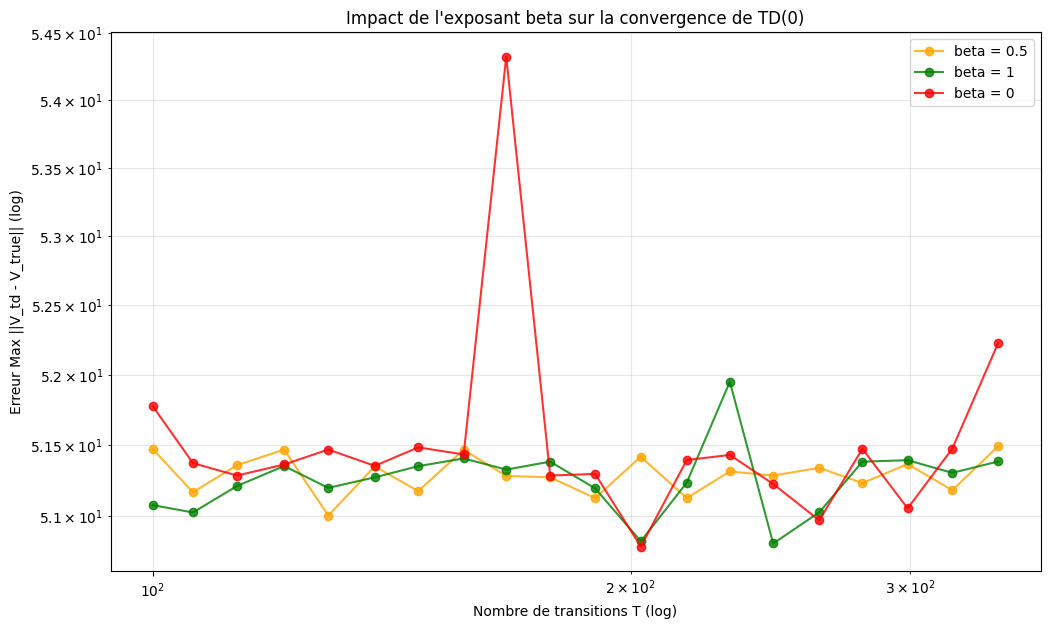

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
beta_list = [0.5, 1, 0]
colors = {0.5: 'orange', 1: 'green', 0: 'red'}

# Calcul du T max 
T_max = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma))

# On définit les étapes T 
T_values = np.geomspace(100, T_max, num=20, dtype=int)
T_values = np.unique(T_values) 

# On suppose que V_true est déjà calculé
# V_true = EvaluatePolicy(PiThreshold) 

plt.figure(figsize=(12, 7))
print("Lancement des simulations...")

# --- Double boucle imbriquée ---
for beta in beta_list:
    print(f"Test avec beta = {beta}...")
    errors = [] # Liste pour stocker l'erreur à chaque étape T
    
    for T in T_values:
        # Lance TD0 sans le modifier, pour une durée T
        V_est = TD0(PiThreshold, T, beta)
        
        # Calcul de l'erreur (Norme infinie)
        # On compare le V estimé par TD0 avec le V réel (V_true)
        error = np.max(np.abs(V_est - V_true))
        errors.append(error)
        
    
    plt.plot(T_values, errors, label=f'beta = {beta}', color=colors[beta], marker='o', alpha=0.8)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nombre de transitions T (log)')
plt.ylabel('Erreur Max ||V_td - V_true|| (log)')
plt.title('Impact de l\'exposant beta sur la convergence de TD(0)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

## Every-visit Monte-Carlo, or TD(1)

Every-visit Monte-Carlo starts from an arbitrary value vector. At each iteration, it generates a trajectory of length $H$ from a random state $s_1$. After that trajectory is done, it updates the value of each state visited $s_k$ by

$V(s_k) \leftarrow V(s_k) + \alpha_{N(s_k)}(\sum_{t=k}^{H}\gamma^{t - k} r_t - V(s_k))$

(implementation hint: start from the last state, and go backwards until $s_1$)

See lecture 3 for more details.

**Implement every-visit Monte-Carlo and compare the computed value to the value returned by policy iteration. Vary the number of trajectories and the trajectory length and comment on the effect of those parameters.**

In [12]:
def TD1(Pi, H, T):  # Pi: policy to be evaluated, H: number of iterations in a trajectory, T: number of trajectories
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    for t in range(T):
        s0 = np.random.randint(M+1)
        env = StoreManagement(s0)

        States, Rewards = SimulateTrajectory(H, Pi, s0)
        
        G = 0.0
        # Go backwards through the trajectory
        for k in reversed(range(len(States))):
            s = int(States[k])
            r = Rewards[k]

            G = r + gamma * G
            N[s] += 1
            alpha = 1.0 / (N[s]**0.5)

            V[s] = V[s] + alpha * (G - V[s])

    return(V)


V_matrix_inversion = EvaluatePolicy(PiThreshold)

V_mc = TD1(PiThreshold, H=50, T=10000)

error = np.linalg.norm(V_mc - V_matrix_inversion)
print("L2 error:", error)

L2 error: 85.46376328965762


H= 20, T=  1000 → L2 error = 78.21
H= 20, T=  5000 → L2 error = 79.90
H= 20, T= 10000 → L2 error = 80.90
H= 20, T= 50000 → L2 error = 78.32
H= 50, T=  1000 → L2 error = 48.63
H= 50, T=  5000 → L2 error = 51.29
H= 50, T= 10000 → L2 error = 48.23
H= 50, T= 50000 → L2 error = 49.37
H=100, T=  1000 → L2 error = 32.05
H=100, T=  5000 → L2 error = 32.34
H=100, T= 10000 → L2 error = 28.75
H=100, T= 50000 → L2 error = 28.04
H=200, T=  1000 → L2 error = 12.11
H=200, T=  5000 → L2 error = 19.50
H=200, T= 10000 → L2 error = 17.00
H=200, T= 50000 → L2 error = 16.05


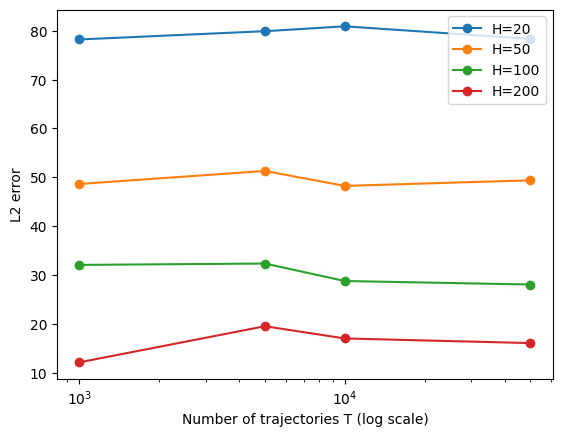

In [13]:
TD1(PiConstant, 100, 10**3)

V_true = EvaluatePolicy(PiConstant)   # matrix inversion / policy iteration

Hs = [20, 50, 100, 200]
Ts = [10**3, 5*10**3, 10**4, 5*10**4]


results = {}

for H in Hs:
    errors = []
    for T in Ts:
        V_mc = TD1(PiConstant, H, T)
        error = np.linalg.norm(V_mc - V_true)
        results[(H, T)] = error
        print(f"H={H:3d}, T={T:6d} → L2 error = {error:.2f}")
        errors.append(error)
    plt.plot(Ts, errors, marker='o', label=f"H={H}")

plt.xscale("log")
plt.xlabel("Number of trajectories T (log scale)")
plt.ylabel("L2 error")
plt.legend()
plt.show()



# Computing the optimal policy: Q-learning

Q-learning does Robbins-Monro updates on all state-action pairs in order to estimate the optimal Q-value $Q^\star$.
Then once $Q^\star$ is well estimated, Q-learning returns the associated greedy policy. The update after observing a transition from state $s$ and action $a$ to a state $s'$ with reward $r$ is

$Q(s, a) \leftarrow Q(s, a) + \alpha_{N(s,a)}(r + \gamma \max_b Q(s', b) - Q(s, a))$

See lecture 3 for a detailed pseudo-code.

**Implement Q-learning**

Take inspiration from your TD(0) code. For the behavior policy, use $\varepsilon$-greedy: with probability $1 - \varepsilon$, take the greedy(Q) action, and with probability $\varepsilon$, take a random action.

In [45]:
def epsilon_greedy(Q, s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])   # random action
    else:
        return np.argmax(Q[s]) 

def Q_learning(T, H, epsilon=0.1):
    """
    Q-learning with epsilon-greedy behavior policy
    
    T       : number of episodes
    H       : horizon (steps per episode)
    epsilon : exploration probability
    gamma   : discount factor
    """
    env0 = StoreManagement(0)
    A = env0.action_space.n
    Q = np.zeros((M + 1, A))         # Q[s, a]
    N = np.zeros((M + 1, A))         # visit counts

    for _ in range(T):
        s = np.random.randint(M + 1)
        env = StoreManagement(s)

        for _ in range(H):
            a = epsilon_greedy(Q, s, epsilon)

            step_out = env.step(a)

            s_next = step_out[0]
            r = step_out[1]
            # Robbins–Monro step size
            N[s, a] += 1
            alpha = 1.0 / (N[s, a]**0.5)

            # Q-learning update
            Q[s, a] += alpha * (
                r + gamma * np.max(Q[s_next]) - Q[s, a]
            )

            s = s_next

    return Q

In [48]:
Q = Q_learning(100_000, 100)
print(np.argmax(Q, axis=1))

[9 8 5 7 3 0 0 0 0 0 0 0 0 0 0 0]


**Compare the policy computed by Q-learning to the optimal policy (computed by policy iteration, for example)**

Look at how the Q-learning policy improves with the number of transitions (with plots). Comment on the number necessary to get a policy with a good value, and on the number needed to obtain the exact optimal policy.

Warning: Q-learning might need a very long time to get the exact policy (a large number of iteration, which might take very long depending on your hardware). It is fine if you don't answer the last part of the question exactly.

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def get_greedy_policy(Q):
    """Extrait la politique gloutonne à partir de Q."""
    return np.argmax(Q, axis=1)

def Q_learning_analysis(T, H, pi_opt, V_opt, epsilon=0.1, check_every=100):
    """
    Q-learning avec monitoring des performances.
    """
    env0 = StoreManagement(0)
    A = env0.action_space.n
    S_size = M + 1 # Suppose que M est défini globalement
    
    Q = np.zeros((S_size, A))
    N = np.zeros((S_size, A))
    
    # Listes pour stocker l'historique des performances
    norm_values = []
    policy_precision = []
    iterations = []

    for episode in range(T):
        s = np.random.randint(S_size)
        env = StoreManagement(s)

        for _ in range(H):
            a = epsilon_greedy(Q, s, epsilon)
            
            # Step
            step_out = env.step(a)
            s_next = step_out[0]
            r = step_out[1]
            
            # Update counts and alpha
            N[s, a] += 1
            alpha = 1.0 / (N[s, a]**0.5) # Robbins-Monro

            # Update Q
            Q[s, a] += alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
            
            s = s_next

        # --- Monitoring tous les 'check_every' épisodes ---
        if (episode + 1) % check_every == 0:
            # 1. Calcul de la politique courante
            pi_curr = get_greedy_policy(Q)
            
            # 2. Comparaison avec la politique optimale (% d'actions correctes)
            accuracy = np.mean(pi_curr == pi_opt)
            policy_precision.append(accuracy)
            
            # 3. Comparaison des valeurs (Convergence de Q vers V*)
            # V_Q est la valeur max estimée par Q-learning pour chaque état
            V_Q = np.max(Q, axis=1)
            # On mesure la distance L-infini (erreur max)
            error = np.max(np.abs(V_opt - V_Q))
            norm_values.append(error)
            
            iterations.append(episode + 1)

    return Q, iterations, norm_values, policy_precision

# --- Lancement de l'expérience ---
# Paramètres (ajuste T selon la vitesse de ton ordi)
T_episodes = 20000  
H_horizon = 100     

pi_opt = PiThreshold
V_opt = EvaluatePolicy(PiThreshold)

S_size = len(V_opt) 
pi_opt_array = np.zeros(S_size, dtype=int)
for s in range(S_size):
    # Si pi_opt est une fonction qui retourne l'action optimale
    pi_opt_array[s] = pi_opt(s)

# Suppose que pi_opt et V_opt viennent de ton code précédent (Policy Iteration)
Q_final, iters, errors, accs = Q_learning_analysis(T_episodes, H_horizon, pi_opt_array, V_opt)

# Note: Décommente la ligne ci-dessus pour lancer si tes variables sont prêtes.

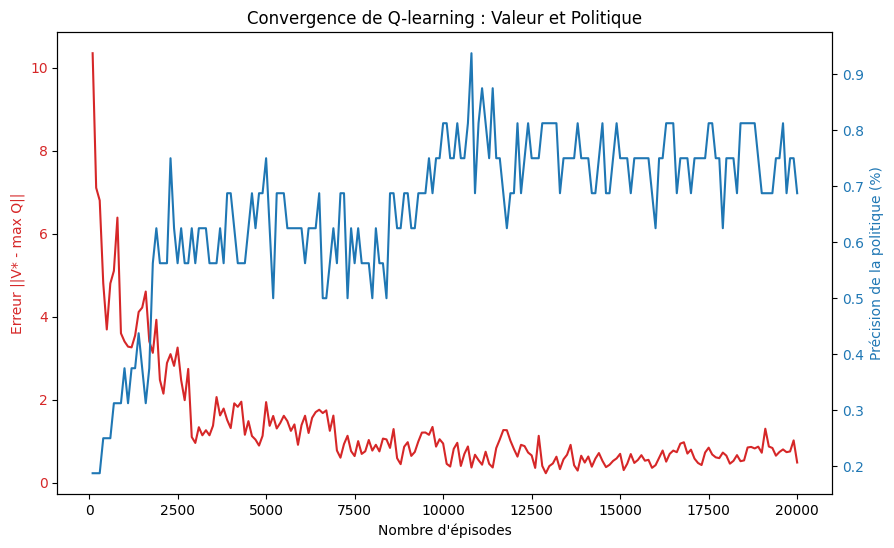

In [47]:
def plot_results(iters, errors, accs):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Nombre d\'épisodes')
    ax1.set_ylabel('Erreur ||V* - max Q||', color=color)
    ax1.plot(iters, errors, color=color, label='Erreur de valeur')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # Deuxième axe Y pour la précision
    color = 'tab:blue'
    ax2.set_ylabel('Précision de la politique (%)', color=color)
    ax2.plot(iters, accs, color=color, label='Précision Politique')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title("Convergence de Q-learning : Valeur et Politique")
    plt.show()

plot_results(iters, errors, accs)

**Investigate the influence of $\varepsilon$ in the $\varepsilon$-greedy behavior policy. Experiment with other heuristics for the behavior policy (for example softmax, and/or other ideas you may have).**

Test avec epsilon = 0.01...
Test avec epsilon = 0.1...
Test avec epsilon = 0.3...
Test avec epsilon = 0.8...


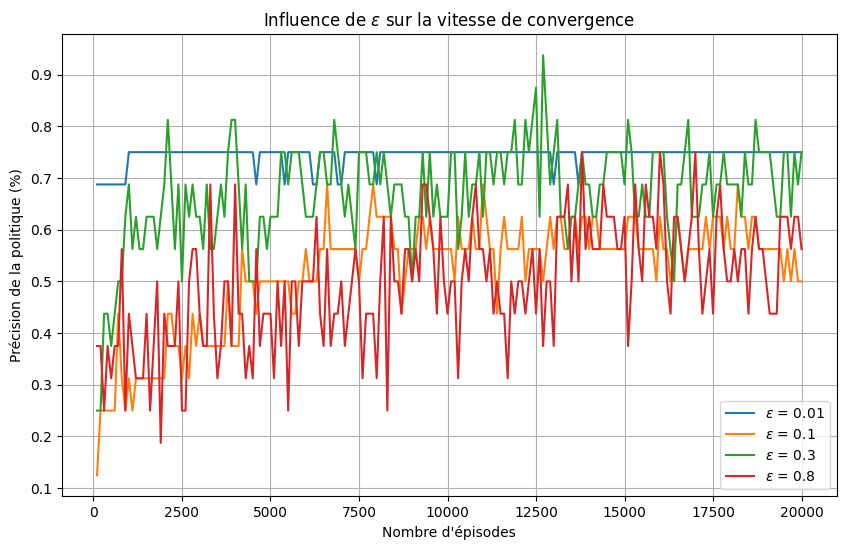

In [49]:
def run_epsilon_experiment(epsilon_values, T, H, pi_opt, V_opt):
    plt.figure(figsize=(10, 6))
    
    for eps in epsilon_values:
        print(f"Test avec epsilon = {eps}...")
        # On réutilise ta fonction d'analyse corrigée
        _, iters, _, accs = Q_learning_analysis(T, H, pi_opt, V_opt, epsilon=eps)
        
        plt.plot(iters, accs, label=f'$\epsilon$ = {eps}')
        
    plt.xlabel("Nombre d'épisodes")
    plt.ylabel("Précision de la politique (%)")
    plt.title("Influence de $\epsilon$ sur la vitesse de convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

# À lancer avec ton pi_opt_array corrigé
run_epsilon_experiment([0.01, 0.1, 0.3, 0.8], T=20000, H=100, pi_opt=pi_opt_array, V_opt=V_opt)

In [ ]:

def softmax_action(Q, s, temperature=1.0):
    # Astuce numérique : soustraire le max pour éviter l'overflow avec exp()
    # Cela ne change pas les probabilités finales
    preferences = Q[s] - np.max(Q[s])
    
    exp_preferences = np.exp(preferences / temperature)
    sum_exp = np.sum(exp_preferences)
    
    probs = exp_preferences / sum_exp
    
    # Choix d'une action selon les probabilités calculées
    return np.random.choice(len(Q[s]), p=probs)


def get_action(Q, s, method, param, episode=0):
    """
    Selectionne l'action selon la méthode choisie.
    method: 'epsilon', 'softmax', 'decaying_epsilon'
    param: valeur de epsilon ou temperature
    """
    if method == 'epsilon':
        if np.random.rand() < param:
            return np.random.randint(Q.shape[1])
        else:
            return np.argmax(Q[s])
            
    elif method == 'softmax':
        return softmax_action(Q, s, temperature=param)
        
    elif method == 'decaying_epsilon':
        # Exemple : epsilon commence à 1.0 et diminue
        # param peut être le taux de décroissance
        eps_t = 1.0 / (1 + 0.001 * episode) # Décroissance simple
        # Ou une décroissance exponentielle :
        # eps_t = 1.0 * (0.9995 ** episode)
        
        if np.random.rand() < eps_t:
            return np.random.randint(Q.shape[1])
        else:
            return np.argmax(Q[s])
            
    return np.argmax(Q[s]) # Default greedy

def Q_learning_modular(T, H, pi_opt, method='epsilon', param=0.1):
    env0 = StoreManagement(0)
    A = env0.action_space.n
    S_size = M + 1
    Q = np.zeros((S_size, A))
    N = np.zeros((S_size, A))
    
    policy_precision = []
    iterations = []
    
    for episode in range(T):
        s = np.random.randint(S_size)
        env = StoreManagement(s)
        
        for _ in range(H):
            # On passe le numéro de l'épisode pour le decaying epsilon
            a = get_action(Q, s, method, param, episode)
            
            step_out = env.step(a)
            s_next, r = step_out[0], step_out[1]
            
            N[s, a] += 1
            alpha = 1.0 / (N[s, a]**0.5)
            Q[s, a] += alpha * (r + 0.99 * np.max(Q[s_next]) - Q[s, a]) # Check ton gamma
            s = s_next
            
        if (episode + 1) % 500 == 0:
            pi_curr = np.argmax(Q, axis=1)
            acc = np.mean(pi_curr == pi_opt)
            policy_precision.append(acc)
            iterations.append(episode)
            
    return iterations, policy_precision

# --- Comparaison finale ---
plt.figure(figsize=(10, 6))

# 1. Test Epsilon fixe
x, y = Q_learning_modular(20000, 100, pi_opt_array, 'epsilon', 0.1)
plt.plot(x, y, label='Epsilon-Greedy (0.1)')

# 2. Test Softmax
x, y = Q_learning_modular(20000, 100, pi_opt_array, 'softmax', 1.0) # Ajuste la température
plt.plot(x, y, label='Softmax (T=1.0)')

# 3. Test Decaying Epsilon
x, y = Q_learning_modular(20000, 100, pi_opt_array, 'decaying_epsilon', 0)
plt.plot(x, y, label='Decaying Epsilon', linewidth=2, linestyle='--')

plt.legend()
plt.title("Comparaison des stratégies d'exploration")
plt.xlabel("Épisodes")
plt.ylabel("Précision (%)")
plt.show()